In [130]:
from process_data import clean_data, create_index, pivot_data
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import load_model
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [131]:
def data_lstm(X,y,lookback=1):
    newX = []
    newY = []
    for i in range(len(y)-lookback):
        newX.append(X[i:i+1+lookback,:])
        newY.append(y[i+lookback])
    return np.array(newX), np.array(newY)


def create_rnn(lookback,num_features):
    model = Sequential()
    model.add(LSTM(return_sequences=True, batch_input_shape=(24,lookback+1,num_features), units=16, stateful=True))
    #model.add(Dropout(0.05))

    model.add(LSTM(units=8,return_sequences=True, stateful=True))
    #model.add(Dropout(0.05))
    
    model.add(LSTM(units=4,stateful=True))
    #model.add(Dropout(0.05))
    
    model.add(Dense(units=1))
    model.add(Activation('linear'))

    start = time.time()
    model.compile(loss='mse', optimizer='adadelta')
    print('compilation time : {}'.format(time.time() - start))
    print(model.summary())
    return model


def train_rnn(df,date_predict,lookback,epochs=100):
    #Preparting data to Train
    #print('Preparing data to Train')
    date_p = datetime.datetime.strptime(date_predict, "%Y-%m-%d").date()
    date_limit = (date_p - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    date_start = (date_p - datetime.timedelta(days=40+lookback//24)).strftime('%Y-%m-%d')
    sk = df[:date_limit].copy()
    print(sk.shape)
    sk = sk.drop(['TRADEDATE', 'RTENERGY'], axis=1)

    #sk.hourofday = sk.hourofday.dt.seconds/3600
    sk = sk[date_start:]
    print(sk.shape)
    y = sk.pop('DAENERGY').values
    X = sk.values[:,1:]
    X,y = data_lstm(X,y,lookback)
    print(X.shape)
    model = create_rnn_2(lookback,X.shape[2])

    #X = X.reshape(X.shape[0],X.shape[1],1)
    filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
    filepath="best_model_lstm_new.hdf5"

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    #early_stop = EarlyStopping(monitor='val_loss', patience=100, verbose=1)
    tensorboard = TensorBoard(log_dir='./logs/'+str(time.time()), 
                              histogram_freq=0, 
                              batch_size=24, 
                              write_graph=True, 
                              write_grads=False, 
                              write_images=True, 
                              )
    # #Training Model
    model.fit(
        X,
        y,
        batch_size=24,  #168, 
        epochs=epochs,
        shuffle = False,
        validation_split=0.05, callbacks=[tensorboard, checkpoint])  #0.0857

    #preparing data to Predict
    return model, X, y

def predict_day(date_predict,model,lookback=168):
    date_p = datetime.datetime.strptime(date_predict, "%Y-%m-%d").date()
    date_limit = (date_p - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    date_start = (date_p - datetime.timedelta(days=42)).strftime('%Y-%m-%d')

    df_predict = df.copy()
    df_predict = df_predict[:date_predict]

    df_predict = df_predict.drop(['TRADEDATE', 'RTENERGY'], axis=1)

    #df_predict.hourofday = df_predict.hourofday.dt.seconds/3600
    df_predict = df_predict[date_start:]
    y = df_predict.pop('DAENERGY').values
    X = df_predict.values[:,1:]
    X,y = data_lstm(X,y,lookback)

    input_p = X[-24:]   #-24
    pred = model.predict(input_p,batch_size=24)

    results = df[date_limit:date_predict].copy()
    # pred_ada = model.predict(input_p.values)
    results['forecast'] = pred
    RMSE = get_rmse(results['DAENERGY'].values, pred)
    return results, RMSE

def plot_results(results,date_predict):
    RMSE = get_rmse(results['DAENERGY'], results['forecast'])
    fig, ax = plt.subplots(figsize=(9,4))
    # npre = 24
    ax.set(title='DAENERGY '+ 'RMSE: {:.3f} for {}'.format(RMSE, date_predict), xlabel='Date', ylabel='Price DAENERGY')
    #
    # # Plot data points
    results['DAENERGY'].plot(ax=ax, style='o', label='Observed')
    #
    # # Plot predictions
    results.forecast.plot(ax=ax, style='r--', label='forecast')
    # #ci = predict_ci.loc[date_predict]
    # #ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
    legend = ax.legend(loc='lower right')


def get_rmse(pred,real):
    return np.sqrt(((pred-real)**2).sum()/pred.shape[0])

def create_date_range(start_date, end_date):
    start_dt = datetime.datetime.strptime(start_date, "%Y-%m-%d").date()
    end_dt = datetime.datetime.strptime(end_date, "%Y-%m-%d").date()
    dates = []
    cur_dt = start_dt
    dates.append(start_date)
    while cur_dt<end_dt:
        cur_dt = cur_dt + datetime.timedelta(days=1)
        dates.append(cur_dt.strftime('%Y-%m-%d'))
    return dates


def create_features(df):
    df = df.copy()
    features = ['Ph-1', 'Ph-2', 'Ph-3', 'Ph-24', 'Ph-25', 'Ph-48', 'Ph-49',
                'Ph-72','Ph-73', 'Ph-96', 'Ph-97', 'Ph-120', 'Ph-121', 'Ph-144',
                'Ph-145', 'Ph-168']
    deltas = [1, 2, 3, 24, 25, 48, 49, 72, 73, 96, 97, 120, 121, 144, 145, 168]

    for col, shift in zip(features, deltas):
        df[col] = df.DAENERGY.shift(shift)
    return df

def create_rollings(df):
    df = df.copy()
    means_cols = ['mean_3','mean_6','mean_9','mean_12','mean_24']
    means_values = [3,6,9,12,24]
    
    for col, val in zip(means_cols, means_values):
        df[col] = pd.Series.rolling(df.DAENERGY, window=val, center = False).mean()
        df[col] = df[col].shift(24)
    
    df['p_1'] = df.DAENERGY.shift(1)
    df['p_24'] = df.DAENERGY.shift(24)
    df['p_48'] = df.DAENERGY.shift(48)
    return df        

def MAPE(y_true, y_pred):
    return 1.0/len(y_true)*(np.abs((y_true-y_pred))/y_true*100).sum()

from keras.optimizers import RMSprop, Adam, Adadelta

def create_rnn_2(lookback, num_features):
    model = Sequential()
    model.add(LSTM(return_sequences=True, batch_input_shape=(24,lookback+1,num_features), units=16, stateful=True))
    #model.add(Dropout(0.05))

    model.add(LSTM(units=8,return_sequences=True, stateful=True))
    #model.add(Dropout(0.1))
    
    model.add(LSTM(units=4,stateful=True))
    #model.add(Dropout(0.1))
    
    model.add(Dense(units=1))
    model.add(Activation('linear'))

    #optim = RMSprop(lr=0.01)
    #optim = Adadelta()
    start = time.time()
    model.compile(loss='mse', optimizer = 'adadelta')
    print('compilation time : {}'.format(time.time() - start))
    print(model.summary())
    return model

In [132]:
df = pivot_data('../data/Data.txt')
#scaler = MinMaxScaler(feature_range=(-1,1)).fit(df.DAENERGY)
#df.DAENERGY = scaler.transform(df.DAENERGY)
df = clean_data(df)
df = create_index(df)
df = create_rollings(df)
df = df.dropna()
list_scalers = dict()
for c in df.columns.values:
    list_scalers[c] = MinMaxScaler()
    list_scalers[c].fit(df[c].values.reshape(-1,1))
    df[c] = list_scalers[c].transform(df[c].values.reshape(-1,1))
print('Training the model...')

lookback=48

Training the model...


In [133]:
#df.DAENERGY = list_scalers['DAENERGY'].inverse_transform(df.DAENERGY.values)
model, X, y = train_rnn(df,'2017-10-01',lookback=lookback,epochs=500)

(2063, 151)
(1008, 149)
(960, 49, 147)
compilation time : 0.00777578353882
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (24, 49, 16)              10496     
_________________________________________________________________
lstm_56 (LSTM)               (24, 49, 8)               800       
_________________________________________________________________
lstm_57 (LSTM)               (24, 4)                   208       
_________________________________________________________________
dense_19 (Dense)             (24, 1)                   5         
_________________________________________________________________
activation_19 (Activation)   (24, 1)                   0         
Total params: 11,509
Trainable params: 11,509
Non-trainable params: 0
_________________________________________________________________
None
Train on 912 samples, validate on 48 samples
Epoch 1/500
9

912/912 [==============================] - 3s - loss: 0.0032 - val_loss: 0.0034
Epoch 35/500
912/912 [==============================] - 3s - loss: 0.0031 - val_loss: 0.0034
Epoch 36/500
912/912 [==============================] - 3s - loss: 0.0031 - val_loss: 0.0034
Epoch 37/500
912/912 [==============================] - 3s - loss: 0.0031 - val_loss: 0.0034
Epoch 38/500
912/912 [==============================] - 3s - loss: 0.0030 - val_loss: 0.0035
Epoch 39/500
912/912 [==============================] - 3s - loss: 0.0030 - val_loss: 0.0036
Epoch 40/500
912/912 [==============================] - 3s - loss: 0.0030 - val_loss: 0.0036
Epoch 41/500
912/912 [==============================] - 3s - loss: 0.0029 - val_loss: 0.0037
Epoch 42/500
912/912 [==============================] - 3s - loss: 0.0029 - val_loss: 0.0037
Epoch 43/500
912/912 [==============================] - 3s - loss: 0.0029 - val_loss: 0.0038
Epoch 44/500
912/912 [==============================] - 3s - loss: 0.0029 - val_los

912/912 [==============================] - 3s - loss: 0.0021 - val_loss: 0.0067
Epoch 77/500
912/912 [==============================] - 3s - loss: 0.0021 - val_loss: 0.0069
Epoch 78/500
912/912 [==============================] - 3s - loss: 0.0021 - val_loss: 0.0070
Epoch 79/500
912/912 [==============================] - 3s - loss: 0.0020 - val_loss: 0.0072
Epoch 80/500
912/912 [==============================] - 3s - loss: 0.0020 - val_loss: 0.0073
Epoch 81/500
912/912 [==============================] - 3s - loss: 0.0020 - val_loss: 0.0075
Epoch 82/500
912/912 [==============================] - 3s - loss: 0.0020 - val_loss: 0.0076
Epoch 83/500
912/912 [==============================] - 3s - loss: 0.0020 - val_loss: 0.0078
Epoch 84/500
912/912 [==============================] - 3s - loss: 0.0020 - val_loss: 0.0079
Epoch 85/500
912/912 [==============================] - 3s - loss: 0.0020 - val_loss: 0.0081
Epoch 86/500
912/912 [==============================] - 3s - loss: 0.0019 - val_los

912/912 [==============================] - 3s - loss: 0.0017 - val_loss: 0.0070
Epoch 118/500
912/912 [==============================] - 3s - loss: 0.0018 - val_loss: 0.0070
Epoch 119/500
912/912 [==============================] - 3s - loss: 0.0017 - val_loss: 0.0070
Epoch 120/500
912/912 [==============================] - 3s - loss: 0.0016 - val_loss: 0.0056
Epoch 121/500
912/912 [==============================] - 3s - loss: 0.0016 - val_loss: 0.0061
Epoch 122/500
912/912 [==============================] - 3s - loss: 0.0016 - val_loss: 0.0071
Epoch 123/500
912/912 [==============================] - 3s - loss: 0.0017 - val_loss: 0.0067
Epoch 124/500
912/912 [==============================] - 3s - loss: 0.0018 - val_loss: 0.0079
Epoch 125/500
912/912 [==============================] - 3s - loss: 0.0024 - val_loss: 0.0074
Epoch 126/500
912/912 [==============================] - 3s - loss: 0.0017 - val_loss: 0.0061
Epoch 127/500
912/912 [==============================] - 3s - loss: 0.0015

912/912 [==============================] - 3s - loss: 0.0013 - val_loss: 0.0054
Epoch 160/500
912/912 [==============================] - 3s - loss: 0.0012 - val_loss: 0.0052
Epoch 161/500
912/912 [==============================] - 3s - loss: 0.0016 - val_loss: 0.0046
Epoch 162/500
912/912 [==============================] - 3s - loss: 0.0014 - val_loss: 0.0040
Epoch 163/500
912/912 [==============================] - 3s - loss: 0.0013 - val_loss: 0.0039
Epoch 164/500
912/912 [==============================] - 3s - loss: 0.0014 - val_loss: 0.0050
Epoch 165/500
912/912 [==============================] - 3s - loss: 0.0012 - val_loss: 0.0041
Epoch 166/500
912/912 [==============================] - 3s - loss: 0.0015 - val_loss: 0.0058
Epoch 167/500
912/912 [==============================] - 3s - loss: 0.0012 - val_loss: 0.0039
Epoch 168/500
912/912 [==============================] - 3s - loss: 0.0013 - val_loss: 0.0033
Epoch 169/500
912/912 [==============================] - 3s - loss: 0.0016

912/912 [==============================] - 3s - loss: 9.8587e-04 - val_loss: 0.0039
Epoch 198/500
912/912 [==============================] - 3s - loss: 0.0013 - val_loss: 0.0021
Epoch 199/500
912/912 [==============================] - 3s - loss: 9.7237e-04 - val_loss: 0.0042
Epoch 200/500
912/912 [==============================] - 3s - loss: 0.0013 - val_loss: 0.0033
Epoch 201/500
912/912 [==============================] - 3s - loss: 0.0011 - val_loss: 0.0035
Epoch 202/500
912/912 [==============================] - 3s - loss: 0.0010 - val_loss: 0.0036
Epoch 203/500
912/912 [==============================] - 3s - loss: 0.0012 - val_loss: 0.0032
Epoch 204/500
912/912 [==============================] - 3s - loss: 0.0013 - val_loss: 0.0032
Epoch 205/500
912/912 [==============================] - 3s - loss: 9.5722e-04 - val_loss: 0.0033
Epoch 206/500
912/912 [==============================] - 3s - loss: 0.0013 - val_loss: 0.0029
Epoch 207/500
912/912 [==============================] - 3s - 

912/912 [==============================] - 3s - loss: 0.0010 - val_loss: 0.0034
Epoch 239/500
912/912 [==============================] - 3s - loss: 0.0010 - val_loss: 0.0024
Epoch 240/500
912/912 [==============================] - 3s - loss: 7.8349e-04 - val_loss: 0.0030
Epoch 241/500
912/912 [==============================] - 3s - loss: 9.8697e-04 - val_loss: 0.0025
Epoch 242/500
912/912 [==============================] - 3s - loss: 0.0011 - val_loss: 0.0026
Epoch 243/500
912/912 [==============================] - 3s - loss: 8.0178e-04 - val_loss: 0.0026
Epoch 244/500
912/912 [==============================] - 3s - loss: 0.0010 - val_loss: 0.0035
Epoch 245/500
912/912 [==============================] - 3s - loss: 9.5782e-04 - val_loss: 0.0020
Epoch 246/500
912/912 [==============================] - 3s - loss: 8.8708e-04 - val_loss: 0.0031
Epoch 247/500
912/912 [==============================] - 3s - loss: 9.7441e-04 - val_loss: 0.0027
Epoch 248/500
912/912 [===========================

912/912 [==============================] - 3s - loss: 6.8164e-04 - val_loss: 0.0030
Epoch 278/500
912/912 [==============================] - 3s - loss: 5.6831e-04 - val_loss: 0.0018
Epoch 279/500
912/912 [==============================] - 3s - loss: 0.0012 - val_loss: 0.0013
Epoch 280/500
912/912 [==============================] - 3s - loss: 7.1822e-04 - val_loss: 0.0029
Epoch 281/500
912/912 [==============================] - 3s - loss: 7.2777e-04 - val_loss: 0.0032
Epoch 282/500
912/912 [==============================] - 3s - loss: 7.6248e-04 - val_loss: 0.0031
Epoch 283/500
912/912 [==============================] - 3s - loss: 6.6558e-04 - val_loss: 0.0025
Epoch 284/500
912/912 [==============================] - 3s - loss: 8.6587e-04 - val_loss: 0.0029
Epoch 285/500
912/912 [==============================] - 3s - loss: 5.7474e-04 - val_loss: 0.0018
Epoch 286/500
912/912 [==============================] - 3s - loss: 7.6609e-04 - val_loss: 0.0036
Epoch 287/500
912/912 [===============

912/912 [==============================] - 3s - loss: 5.5220e-04 - val_loss: 0.0021
Epoch 318/500
912/912 [==============================] - 3s - loss: 6.4075e-04 - val_loss: 0.0027
Epoch 319/500
912/912 [==============================] - 3s - loss: 5.2569e-04 - val_loss: 0.0016
Epoch 320/500
912/912 [==============================] - 3s - loss: 0.0010 - val_loss: 0.0035
Epoch 321/500
912/912 [==============================] - 3s - loss: 6.2146e-04 - val_loss: 0.0020
Epoch 322/500
912/912 [==============================] - 3s - loss: 5.1773e-04 - val_loss: 0.0024
Epoch 323/500
912/912 [==============================] - 3s - loss: 6.4477e-04 - val_loss: 0.0032
Epoch 324/500
912/912 [==============================] - 3s - loss: 6.8404e-04 - val_loss: 0.0035
Epoch 325/500
912/912 [==============================] - 3s - loss: 6.9128e-04 - val_loss: 0.0014
Epoch 326/500
912/912 [==============================] - 3s - loss: 5.5061e-04 - val_loss: 0.0025
Epoch 327/500
912/912 [===============

912/912 [==============================] - 3s - loss: 6.0476e-04 - val_loss: 0.0020
Epoch 358/500
912/912 [==============================] - 3s - loss: 6.1020e-04 - val_loss: 0.0020
Epoch 359/500
912/912 [==============================] - 3s - loss: 5.9638e-04 - val_loss: 0.0017
Epoch 360/500
912/912 [==============================] - 3s - loss: 6.0269e-04 - val_loss: 0.0018
Epoch 361/500
912/912 [==============================] - 3s - loss: 5.6714e-04 - val_loss: 0.0021
Epoch 362/500
912/912 [==============================] - 3s - loss: 5.9639e-04 - val_loss: 0.0021
Epoch 363/500
912/912 [==============================] - 3s - loss: 4.4128e-04 - val_loss: 0.0019
Epoch 364/500
912/912 [==============================] - 3s - loss: 6.8572e-04 - val_loss: 0.0033
Epoch 365/500
912/912 [==============================] - 3s - loss: 5.1204e-04 - val_loss: 0.0018
Epoch 366/500
912/912 [==============================] - 3s - loss: 7.6480e-04 - val_loss: 0.0036
Epoch 367/500
912/912 [===========

912/912 [==============================] - 3s - loss: 4.8413e-04 - val_loss: 0.0023
Epoch 398/500
912/912 [==============================] - 3s - loss: 5.2349e-04 - val_loss: 0.0037
Epoch 399/500
912/912 [==============================] - 3s - loss: 5.2099e-04 - val_loss: 0.0025
Epoch 400/500
912/912 [==============================] - 3s - loss: 4.7859e-04 - val_loss: 0.0020
Epoch 401/500
912/912 [==============================] - 3s - loss: 6.7104e-04 - val_loss: 0.0032
Epoch 402/500
912/912 [==============================] - 3s - loss: 5.3092e-04 - val_loss: 0.0024
Epoch 403/500
912/912 [==============================] - 3s - loss: 4.3212e-04 - val_loss: 0.0017
Epoch 404/500
912/912 [==============================] - 3s - loss: 5.3485e-04 - val_loss: 0.0020
Epoch 405/500
912/912 [==============================] - 3s - loss: 5.2433e-04 - val_loss: 0.0028
Epoch 406/500
912/912 [==============================] - 3s - loss: 4.8999e-04 - val_loss: 0.0017
Epoch 407/500
912/912 [===========

912/912 [==============================] - 7s - loss: 4.3038e-04 - val_loss: 0.0019
Epoch 438/500
912/912 [==============================] - 7s - loss: 5.8479e-04 - val_loss: 0.0030
Epoch 439/500
912/912 [==============================] - 7s - loss: 4.9459e-04 - val_loss: 0.0022
Epoch 440/500
912/912 [==============================] - 7s - loss: 6.6458e-04 - val_loss: 0.0034
Epoch 441/500
912/912 [==============================] - 7s - loss: 4.0575e-04 - val_loss: 0.0026
Epoch 442/500
912/912 [==============================] - 7s - loss: 4.8567e-04 - val_loss: 0.0041
Epoch 443/500
912/912 [==============================] - 7s - loss: 7.1210e-04 - val_loss: 0.0034
Epoch 444/500
912/912 [==============================] - 7s - loss: 4.9039e-04 - val_loss: 0.0036
Epoch 445/500
912/912 [==============================] - 7s - loss: 3.8414e-04 - val_loss: 0.0030
Epoch 446/500
912/912 [==============================] - 7s - loss: 7.2719e-04 - val_loss: 0.0035
Epoch 447/500
912/912 [===========

912/912 [==============================] - 7s - loss: 4.3811e-04 - val_loss: 0.0023
Epoch 478/500
912/912 [==============================] - 7s - loss: 4.5835e-04 - val_loss: 0.0022
Epoch 479/500
912/912 [==============================] - 7s - loss: 5.9660e-04 - val_loss: 0.0020
Epoch 480/500
912/912 [==============================] - 7s - loss: 4.3978e-04 - val_loss: 0.0021
Epoch 481/500
912/912 [==============================] - 7s - loss: 5.3400e-04 - val_loss: 0.0020
Epoch 482/500
912/912 [==============================] - 7s - loss: 5.6482e-04 - val_loss: 0.0024
Epoch 483/500
912/912 [==============================] - 7s - loss: 3.9329e-04 - val_loss: 0.0017
Epoch 484/500
912/912 [==============================] - 7s - loss: 4.0413e-04 - val_loss: 0.0014
Epoch 485/500
912/912 [==============================] - 7s - loss: 4.7070e-04 - val_loss: 0.0020
Epoch 486/500
912/912 [==============================] - 7s - loss: 3.3042e-04 - val_loss: 0.0013
Epoch 487/500
912/912 [===========

In [82]:
model = load_model('best_model_lstm_new.hdf5')

In [90]:
%matplotlib inline

MAPE mean:5.78


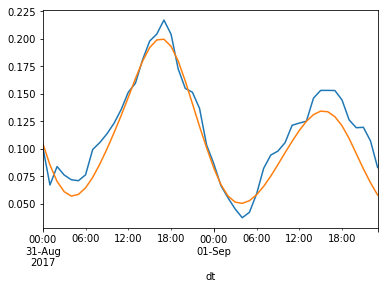

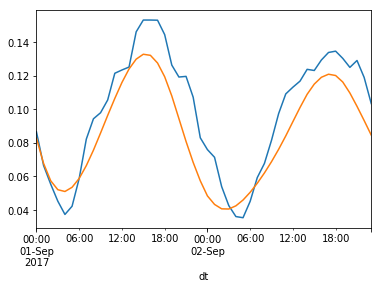

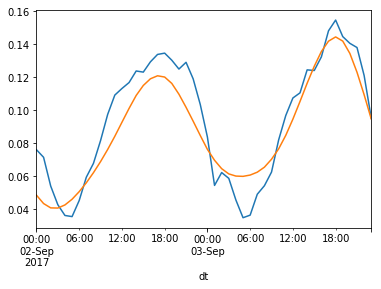

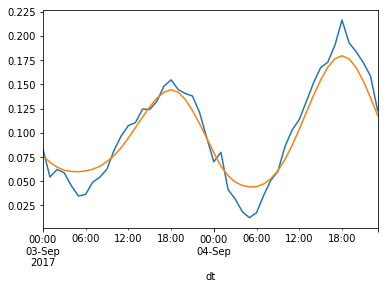

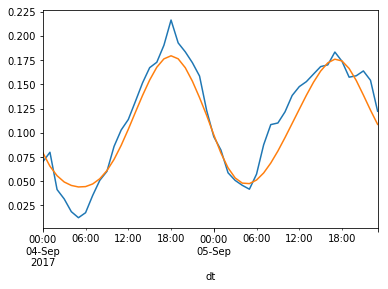

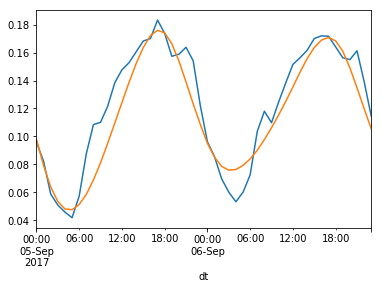

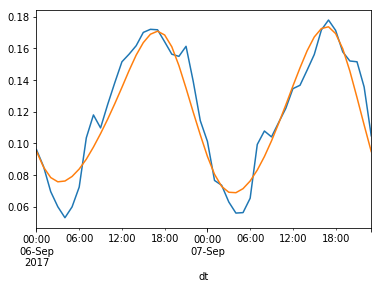

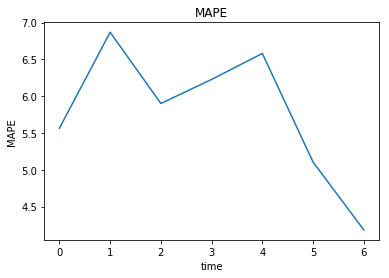

In [119]:
MAPEs = []
for day in create_date_range('2017-09-01','2017-09-07'):
    results, rmse = predict_day(day,model,lookback)
    plt.figure()
    results.DAENERGY.plot()
    results.forecast.plot()
    y_pred = list_scalers['DAENERGY'].inverse_transform(results.forecast.values.reshape(-1,1))
    y_true = list_scalers['DAENERGY'].inverse_transform(results.DAENERGY.values.reshape(-1,1))
    MAPEs.append(MAPE(y_true, y_pred))
plt.figure()
plt.plot(MAPEs)
plt.title('MAPE')
plt.xlabel('time')
plt.ylabel('MAPE')
print('MAPE mean:{:.2f}'.format(np.array(MAPEs).mean()))

MAPE mean:16.28


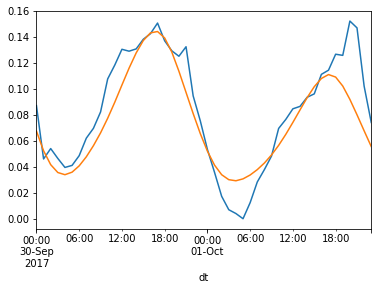

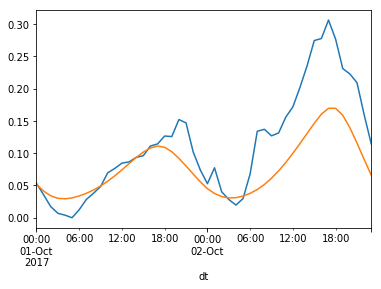

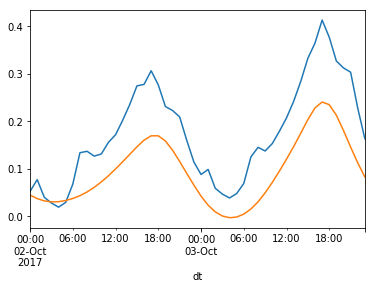

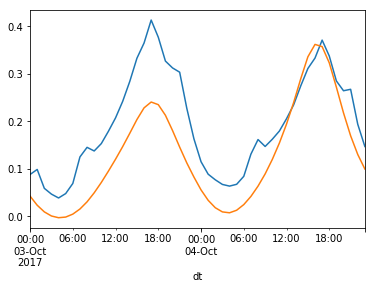

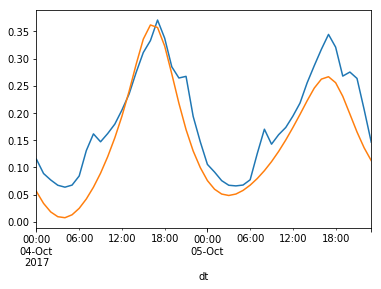

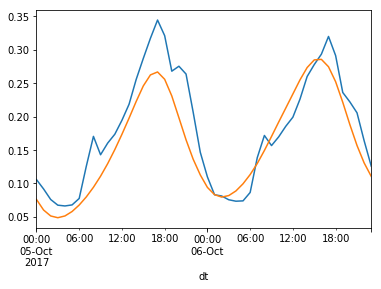

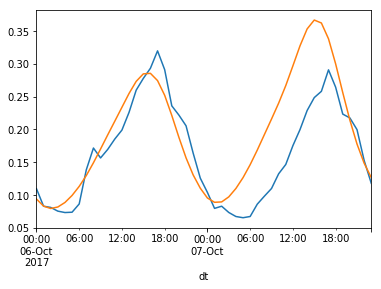

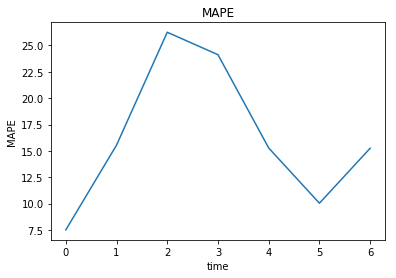

In [120]:
MAPEs=[]
for day in create_date_range('2017-10-01','2017-10-07'):
    results, rmse = predict_day(day,model,lookback)
    plt.figure()
    results.DAENERGY.plot()
    results.forecast.plot()
    y_pred = list_scalers['DAENERGY'].inverse_transform(results.forecast.values.reshape(-1,1))
    y_true = list_scalers['DAENERGY'].inverse_transform(results.DAENERGY.values.reshape(-1,1))
    MAPEs.append(MAPE(y_true, y_pred))
plt.figure()
plt.plot(MAPEs)
plt.title('MAPE')
plt.xlabel('time')
plt.ylabel('MAPE')
print('MAPE mean:{:.2f}'.format(np.array(MAPEs).mean()))

- MAPES:

|Model |MAPE Sept|MAPE Oct|
|:-----|:--------|:-------|
|lookback 48|25.1|22.54|
|| |27.12|

Epoch 10/25
888/912 [============================>.] - ETA: 0s - loss: 0.0046Epoch 00009: val_loss did not improve
912/912 [==============================] - 11s - loss: 0.0046 - val_loss: 0.0078

Epoch 10/10
888/912 [============================>.] - ETA: 0s - loss: 0.0046Epoch 00009: val_loss did not improve
912/912 [==============================] - 2s - loss: 0.0047 - val_loss: 0.0230
Epoch 10/10
888/912 [============================>.] - ETA: 0s - loss: 0.0038Epoch 00009: val_loss did not improve
912/912 [==============================] - 4s - loss: 0.0037 - val_loss: 0.0032   16.82

In [77]:
model, X, y = train_rnn(df,'2017-10-01',lookback=lookback,epochs=500)


(2063, 150)
(1008, 148)
(960, 49, 146)
compilation time : 0.00779509544373
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (24, 49, 16)              10432     
_________________________________________________________________
lstm_32 (LSTM)               (24, 49, 8)               800       
_________________________________________________________________
lstm_33 (LSTM)               (24, 4)                   208       
_________________________________________________________________
dense_11 (Dense)             (24, 1)                   5         
_________________________________________________________________
activation_11 (Activation)   (24, 1)                   0         
Total params: 11,445
Trainable params: 11,445
Non-trainable params: 0
_________________________________________________________________
None
Train on 912 samples, validate on 48 samples
Epoch 1/500
9

912/912 [==============================] - 3s - loss: 0.0029 - val_loss: 0.0034
Epoch 36/500
912/912 [==============================] - 3s - loss: 0.0028 - val_loss: 0.0033
Epoch 37/500
912/912 [==============================] - 3s - loss: 0.0027 - val_loss: 0.0032
Epoch 38/500
912/912 [==============================] - 3s - loss: 0.0026 - val_loss: 0.0031
Epoch 39/500
912/912 [==============================] - 3s - loss: 0.0026 - val_loss: 0.0030
Epoch 40/500
912/912 [==============================] - 3s - loss: 0.0025 - val_loss: 0.0030
Epoch 41/500
912/912 [==============================] - 3s - loss: 0.0025 - val_loss: 0.0030
Epoch 42/500
912/912 [==============================] - 3s - loss: 0.0024 - val_loss: 0.0029
Epoch 43/500
912/912 [==============================] - 3s - loss: 0.0024 - val_loss: 0.0029
Epoch 44/500
912/912 [==============================] - 3s - loss: 0.0023 - val_loss: 0.0029
Epoch 45/500
912/912 [==============================] - 3s - loss: 0.0023 - val_los

912/912 [==============================] - 3s - loss: 0.0015 - val_loss: 0.0039
Epoch 77/500
912/912 [==============================] - 3s - loss: 0.0014 - val_loss: 0.0040
Epoch 78/500
912/912 [==============================] - 3s - loss: 0.0014 - val_loss: 0.0041
Epoch 79/500
912/912 [==============================] - 3s - loss: 0.0014 - val_loss: 0.0042
Epoch 80/500
912/912 [==============================] - 3s - loss: 0.0014 - val_loss: 0.0042
Epoch 81/500
912/912 [==============================] - 3s - loss: 0.0014 - val_loss: 0.0044
Epoch 82/500
912/912 [==============================] - 3s - loss: 0.0014 - val_loss: 0.0044
Epoch 83/500
912/912 [==============================] - 3s - loss: 0.0013 - val_loss: 0.0044
Epoch 84/500
912/912 [==============================] - 3s - loss: 0.0013 - val_loss: 0.0044
Epoch 85/500
912/912 [==============================] - 3s - loss: 0.0013 - val_loss: 0.0044
Epoch 86/500
912/912 [==============================] - 3s - loss: 0.0013 - val_los

KeyboardInterrupt: 

In [51]:
model = load_model('best_model_lstm_new.hdf5')

MAPE mean:9.38


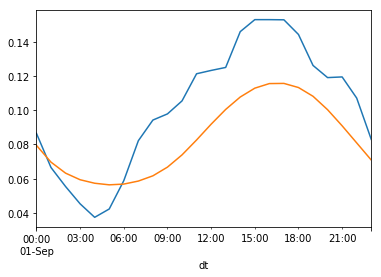

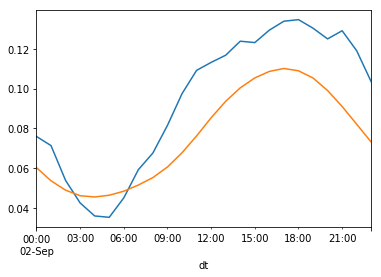

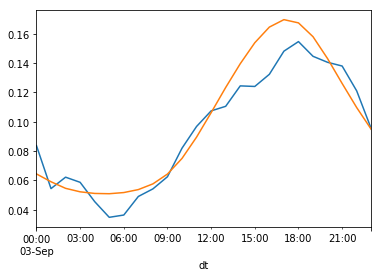

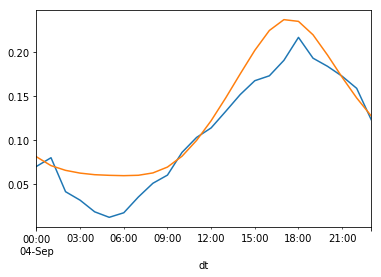

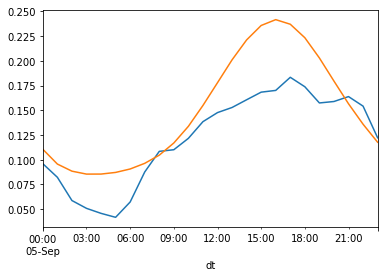

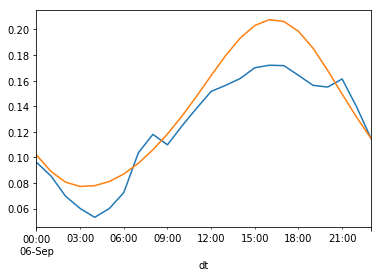

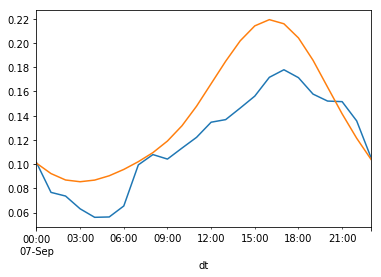

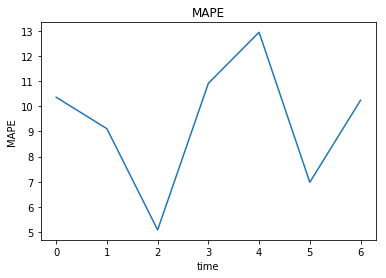

In [52]:
%matplotlib inline
MAPEs = []
for day in create_date_range('2017-09-01','2017-09-07'):
    results, rmse = predict_day(day,model,lookback)
    plt.figure()
    results.DAENERGY.plot()
    results.forecast.plot()
    y_pred = list_scalers['DAENERGY'].inverse_transform(results.forecast.values.reshape(-1,1))
    y_true = list_scalers['DAENERGY'].inverse_transform(results.DAENERGY.values.reshape(-1,1))
    MAPEs.append(MAPE(y_true, y_pred))
plt.figure()
plt.plot(MAPEs)
plt.title('MAPE')
plt.xlabel('time')
plt.ylabel('MAPE')
print('MAPE mean:{:.2f}'.format(np.array(MAPEs).mean()))

MAPE mean:23.92


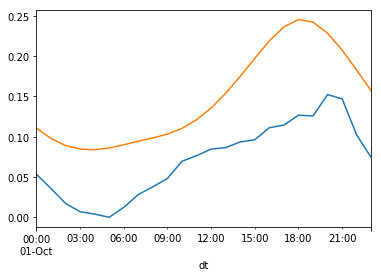

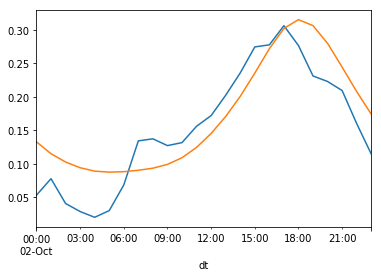

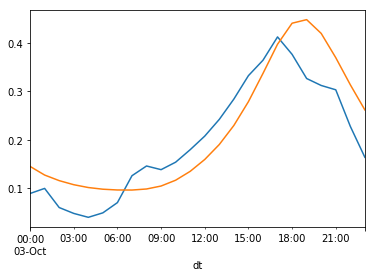

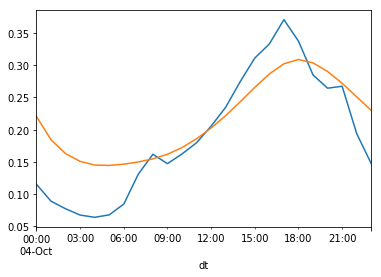

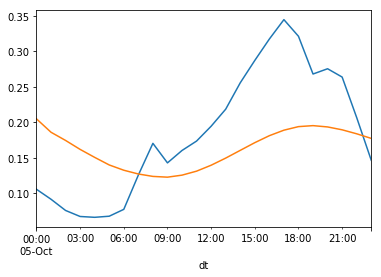

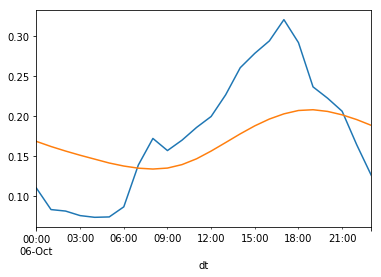

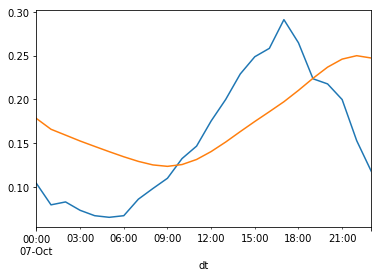

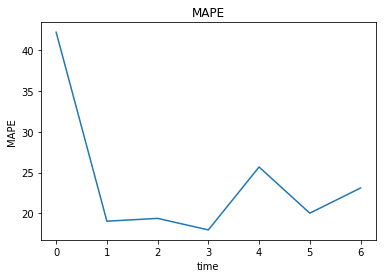

In [53]:
MAPEs=[]
for day in create_date_range('2017-10-01','2017-10-07'):
    results, rmse = predict_day(day,model,lookback)
    plt.figure()
    results.DAENERGY.plot()
    results.forecast.plot()
    y_pred = list_scalers['DAENERGY'].inverse_transform(results.forecast.values.reshape(-1,1))
    y_true = list_scalers['DAENERGY'].inverse_transform(results.DAENERGY.values.reshape(-1,1))
    MAPEs.append(MAPE(y_true, y_pred))
plt.figure()
plt.plot(MAPEs)
plt.title('MAPE')
plt.xlabel('time')
plt.ylabel('MAPE')
print('MAPE mean:{:.2f}'.format(np.array(MAPEs).mean()))

In [54]:
df

REGION,TRADEDATE,HOUROFWEEK,CYWG,K2G4,KABE,KABI,KACT,KACY,KADS,KAKR,...,KVCT,KWRI,KYNG,KZZV,LOAD,DAENERGY,RTENERGY,ISOWIND,OUTAGE,hourofday
dt,,,,,,,,,,,,,,,,,,,,,
2017-07-05 01:00:00,0.000000,0.431138,0.646154,0.634615,0.500000,0.656250,0.705882,0.517241,0.666667,0.607143,...,0.666667,0.491525,0.611111,0.633333,0.372750,0.104037,0.044699,0.308375,0.092918,0.043478
2017-07-05 02:00:00,0.000000,0.437126,0.584615,0.615385,0.517241,0.718750,0.720588,0.500000,0.727273,0.500000,...,0.651515,0.508475,0.481481,0.566667,0.224630,0.077516,0.039790,0.192283,0.064306,0.086957
2017-07-05 03:00:00,0.000000,0.443114,0.569231,0.615385,0.500000,0.703125,0.691176,0.500000,0.696970,0.482143,...,0.636364,0.508475,0.481481,0.550000,0.180757,0.070203,0.038474,0.180788,0.064306,0.130435
2017-07-05 04:00:00,0.000000,0.449102,0.553846,0.615385,0.500000,0.671875,0.661765,0.500000,0.666667,0.464286,...,0.621212,0.491525,0.462963,0.533333,0.157194,0.063573,0.037723,0.161814,0.064306,0.173913
2017-07-05 05:00:00,0.000000,0.455090,0.523077,0.596154,0.500000,0.625000,0.647059,0.482759,0.666667,0.446429,...,0.606061,0.491525,0.444444,0.533333,0.153534,0.061135,0.036666,0.161430,0.064306,0.217391
2017-07-05 06:00:00,0.000000,0.461078,0.523077,0.615385,0.534483,0.609375,0.632353,0.517241,0.651515,0.482143,...,0.590909,0.525424,0.481481,0.533333,0.185521,0.068058,0.037511,0.158961,0.064306,0.260870
2017-07-05 07:00:00,0.000000,0.467066,0.553846,0.653846,0.568966,0.609375,0.632353,0.568966,0.636364,0.535714,...,0.606061,0.559322,0.537037,0.583333,0.236064,0.081123,0.039085,0.139979,0.064306,0.304348
2017-07-05 08:00:00,0.000000,0.473054,0.584615,0.692308,0.620690,0.609375,0.661765,0.620690,0.651515,0.625000,...,0.681818,0.610169,0.611111,0.650000,0.314993,0.096236,0.042420,0.100705,0.064306,0.347826
2017-07-05 09:00:00,0.000000,0.479042,0.646154,0.711538,0.672414,0.671875,0.705882,0.637931,0.681818,0.714286,...,0.757576,0.644068,0.703704,0.733333,0.398355,0.118077,0.046178,0.064853,0.064306,0.391304


In [63]:
pd.Series.rolling(df['2017-10-01'].iloc[0:3].DAENERGY, window=3, center=False).mean()

dt
2017-10-01 00:00:00         NaN
2017-10-01 01:00:00         NaN
2017-10-01 02:00:00    0.035426
Name: DAENERGY, dtype: float64

In [58]:
df['2017-10-01'].DAENERGY

dt
2017-10-01 00:00:00    0.053335
2017-10-01 01:00:00    0.035686
2017-10-01 02:00:00    0.017258
2017-10-01 03:00:00    0.006923
2017-10-01 04:00:00    0.003998
2017-10-01 05:00:00    0.000000
2017-10-01 06:00:00    0.012383
2017-10-01 07:00:00    0.028276
2017-10-01 08:00:00    0.037832
2017-10-01 09:00:00    0.048264
2017-10-01 10:00:00    0.069520
2017-10-01 11:00:00    0.076443
2017-10-01 12:00:00    0.084633
2017-10-01 13:00:00    0.086486
2017-10-01 14:00:00    0.093506
2017-10-01 15:00:00    0.096139
2017-10-01 16:00:00    0.111154
2017-10-01 17:00:00    0.114372
2017-10-01 18:00:00    0.126658
2017-10-01 19:00:00    0.125780
2017-10-01 20:00:00    0.152204
2017-10-01 21:00:00    0.146938
2017-10-01 22:00:00    0.102087
2017-10-01 23:00:00    0.074103
Name: DAENERGY, dtype: float64

In [71]:
X.shape

(960, 49, 139)